In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,  mean_squared_error

In [2]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two PyTorch tensors of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number].values
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    
    # Convert lists of numpy arrays to single numpy arrays
    X_array = np.array(X, dtype=np.float32)
    y_array = np.array(y, dtype=np.float32).reshape(-1, 1)
    
    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.tensor(X_array)
    y_tensor = torch.tensor(y_array)

    return X_tensor, y_tensor

In [3]:
with open('grouped_datetime.pkl', 'rb') as file:
    cdr_data = pickle.load(file)
cdr_data.set_index('time_interval', inplace = True )
cdr_tensor = torch.tensor(cdr_data.values, dtype=torch.float32)
cdr_data.head(10)

,sms_in,sms_out,call_in,call_out,internet
time_interval,,,,,
2013-11-01 00:00:00,26734.588499,20239.160967,10006.074483,11472.884509,642388.341222
2013-11-01 00:10:00,22397.285624,18320.202647,8708.312181,10175.953187,630005.148721
2013-11-01 00:20:00,19697.901226,17062.049977,7917.187587,9230.907121,619933.182580
2013-11-01 00:30:00,18936.405777,15817.010519,7207.441154,8540.273192,590963.037909
2013-11-01 00:40:00,17443.714163,14147.854631,6575.749383,8068.724248,577130.081608
2013-11-01 00:50:00,16924.042149,14268.221651,6016.144075,7317.506059,563293.446691
2013-11-01 01:00:00,15544.169230,13761.794383,5675.190329,6930.658459,543777.683348
2013-11-01 01:10:00,14911.613535,13248.923135,4707.000540,5917.260537,532706.001709
2013-11-01 01:20:00,13827.671207,12276.710377,4574.100163,5657.404865,514802.046032


In [4]:
cdr_tensor[0]

tensor([ 26734.5879,  20239.1602,  10006.0742,  11472.8848, 642388.3125])

In [5]:
len(cdr_tensor)

8928

<AxesSubplot: xlabel='time_interval'>

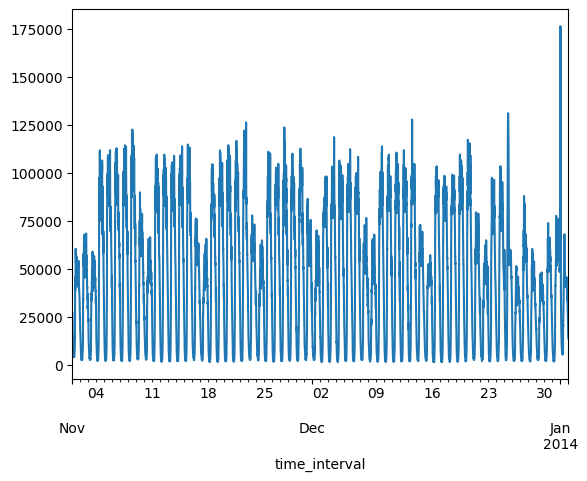

In [6]:
cdr_data['sms_in'].plot()

In [7]:
cdr_data.corr()

,sms_in,sms_out,call_in,call_out,internet
sms_in,1.000000,0.942043,0.959187,0.961628,0.883106
sms_out,0.942043,1.000000,0.875824,0.880881,0.873346
call_in,0.959187,0.875824,1.000000,0.998441,0.868403
call_out,0.961628,0.880881,0.998441,1.000000,0.863860
internet,0.883106,0.873346,0.868403,0.863860,1.000000


In [8]:
window_size = 6  #1 hours

(X, y) = window_data(cdr_data, window_size, 4, 4)

In [9]:
print(X[0])

tensor([642388.3125, 630005.1250, 619933.1875, 590963.0625, 577130.0625,
        563293.4375])


In [10]:
print(y[0])

tensor([543777.6875])


In [11]:
y.shape

torch.Size([8921, 1])

In [12]:
X.shape

torch.Size([8921, 6])

In [13]:
(sms_in, _) = window_data(cdr_data, window_size, 0, 1)
(sms_out, _) = window_data(cdr_data, window_size, 1, 1)
(call_in, _) = window_data(cdr_data, window_size, 2, 1)
(call_out, _) = window_data(cdr_data, window_size, 3, 1)
(internt, _) = window_data(cdr_data, window_size, 4, 1)

In [14]:
sms_in[0]

tensor([26734.5879, 22397.2852, 19697.9004, 18936.4062, 17443.7148, 16924.0430])

In [15]:
sms_out[0]

tensor([20239.1602, 18320.2031, 17062.0508, 15817.0107, 14147.8545, 14268.2217])

In [16]:
call_in[0]

tensor([10006.0742,  8708.3125,  7917.1875,  7207.4409,  6575.7495,  6016.1440])

In [17]:
call_out[0]

tensor([11472.8848, 10175.9531,  9230.9072,  8540.2734,  8068.7241,  7317.5059])

In [18]:
def standard_scale(tensor):
    mean = torch.mean(tensor, 0, keepdim=True)
    std = torch.std(tensor, 0, unbiased=False, keepdim=True)
    return (tensor - mean) / std

X = standard_scale(X)
sms_in = standard_scale(sms_in)
sms_out = standard_scale(sms_out)
call_in = standard_scale(call_in)
call_out = standard_scale(call_out)
internt = standard_scale(internt)


In [19]:
X[0]

tensor([ 0.0906,  0.0353, -0.0097, -0.1393, -0.2011, -0.2629])

In [20]:
split = int(0.8 * len(X))

# Splitting data into training and test sets
X_train = X[:split - 1]
X_test = X[split:]

internt_train = internt[:split - 1]
internt_test = internt[split:]

y_train = y[:split - 1]
y_test = y[split:]

sms_in_train = sms_in[:split - 1]
sms_out_train = sms_out[:split - 1]
call_in_train = call_in[:split - 1]
call_out_train = call_out[:split - 1]

sms_in_test = sms_in[split:]
sms_out_test = sms_out[split:]
call_in_test = call_in[split:]
call_out_test = call_out[split:]

# Reshaping tensors for PyTorch (batch, seq_len, features)
X_train = X_train.unsqueeze(-1)
sms_in_train = sms_in_train.unsqueeze(-1)
sms_out_train = sms_out_train.unsqueeze(-1)
call_in_train = call_in_train.unsqueeze(-1)
call_out_train = call_out_train.unsqueeze(-1)
internt_train = internt_train.unsqueeze(-1)

# Concatenating training data
data_train = torch.cat((sms_in_train, sms_out_train, call_in_train, call_out_train, internt_train), dim=2)

X_test = X_test.unsqueeze(-1)
sms_in_test = sms_in_test.unsqueeze(-1)
sms_out_test = sms_out_test.unsqueeze(-1)
call_in_test = call_in_test.unsqueeze(-1)
call_out_test = call_out_test.unsqueeze(-1)
internt_test = internt_test.unsqueeze(-1)

# Concatenating test data
data_test = torch.cat((sms_in_test, sms_out_test, call_in_test, call_out_test, internt_test), dim=2)

In [21]:
X_train.shape
# This will print a shape like (batch_size, seq_len, n_features)

torch.Size([7135, 6, 1])

In [22]:
y_train.shape

torch.Size([7135, 1])

In [23]:
data_train[0]

tensor([[-0.5475, -0.2972, -0.7345, -0.7664,  0.0906],
        [-0.6745, -0.4269, -0.7822, -0.8094,  0.0353],
        [-0.7536, -0.5119, -0.8112, -0.8408, -0.0097],
        [-0.7759, -0.5961, -0.8373, -0.8637, -0.1393],
        [-0.8197, -0.7089, -0.8605, -0.8794, -0.2011],
        [-0.8349, -0.7008, -0.8810, -0.9043, -0.2629]])

In [24]:
data_train.shape

torch.Size([7135, 6, 5])

In [25]:
X_train[0]

tensor([[ 0.0906],
        [ 0.0353],
        [-0.0097],
        [-0.1393],
        [-0.2011],
        [-0.2629]])

In [26]:
sequence_length = X_train.shape[1]
print("Sequence Length:", sequence_length)

Sequence Length: 6


# 1-variable LSTM

In [27]:
class BasicLSTM(nn.Module):
    def __init__(self, window_size=6, n_features=1):
        super(BasicLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=100, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(100 * window_size, 1500)
        self.fc2 = nn.Linear(1500, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the BasicLSTM model
window_size = 6
n_features = X_train.shape[2]

In [28]:
ls_model = BasicLSTM(window_size=window_size, n_features=n_features)

In [29]:
print(ls_model)

BasicLSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=600, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [30]:
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(ls_model.parameters(), lr=0.001)  # Adam optimizer

In [31]:
epochs = 10
batch_size = 100

lstm_loss = []
# Training loop
for epoch in range(epochs):
    ls_model.train()  # Set the model to training mode
    total_loss = 0

    for i in range(0, len(X_train), batch_size):
        
        # Batch processing
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        optimizer.zero_grad()  # Clear gradients
        outputs = ls_model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        total_loss += loss.item()

    avg_loss = total_loss / len(X_train)
    lstm_loss.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 4923590906.5822
Epoch 2/10, Loss: 3937212424.8981
Epoch 3/10, Loss: 1316071930.4746
Epoch 4/10, Loss: 353271684.7899
Epoch 5/10, Loss: 155292670.3316
Epoch 6/10, Loss: 51408832.0628
Epoch 7/10, Loss: 26537265.3074
Epoch 8/10, Loss: 16705881.4296
Epoch 9/10, Loss: 10825758.6052
Epoch 10/10, Loss: 7058704.1491


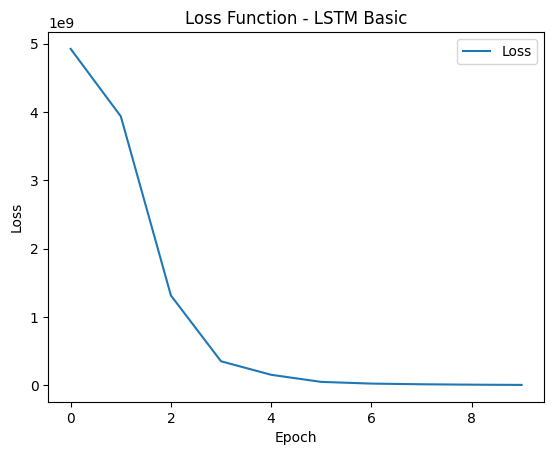

In [32]:
plt.plot(lstm_loss)
plt.title("Loss Function - LSTM Basic")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.show()

In [33]:
ls_model.eval()

BasicLSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=600, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

In [34]:
with torch.no_grad():
    predictions = ls_model(X_test).numpy()
    
# Compute R2 Score
test_r2 = r2_score(y_test, predictions)
print("Test R2 Score:", test_r2)

Test R2 Score: 0.9768604718599793


In [35]:
# Create a DataFrame for Actual vs Predicted Values
lstm_acc_df = pd.DataFrame()
lstm_acc_df['Actual'] = y_test[:, 0]
lstm_acc_df['Predict'] = predictions[:, 0]
lstm_acc_df.head(10)

,Actual,Predict
0,817038.1250,829368.5000
1,817077.1250,827733.8750
2,810135.4375,824096.3750
3,806640.8750,819249.7500
4,812869.4375,813794.5625
5,804164.7500,811622.7500
6,800169.3750,809624.2500
7,805539.5625,807029.8125
8,802202.0625,805829.8750
9,805963.7500,804232.3125


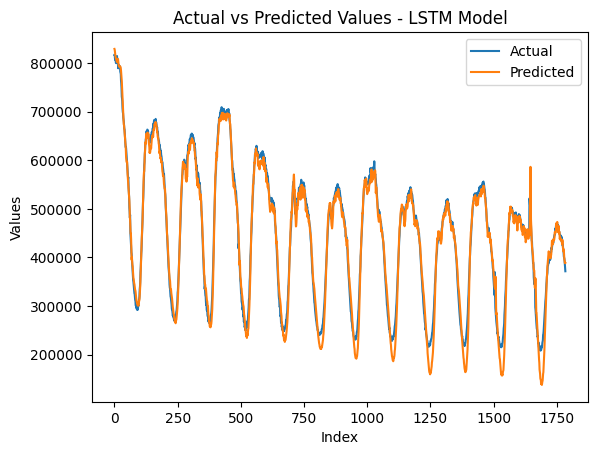

In [36]:
lstm_acc_df.plot()
plt.title("Actual vs Predicted Values - LSTM Model")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(["Actual", "Predicted"])
plt.show()

# 1D Convolution with 1 variable

In [37]:
class BasicConv1D(nn.Module):
    def __init__(self, n_filters=24, fsize=8, window_size=5, n_features=6):
        super(BasicConv1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=n_filters, kernel_size=fsize, padding='same')
        self.fc1 = nn.Linear(n_filters, n_filters * window_size)
        self.fc2 = nn.Linear(n_filters * window_size, 1800)
        self.fc3 = nn.Linear(1800, 100)
        self.fc4 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten the output for the dense layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create an instance of the model
n_filters = 24
fsize = 8
window_size = 5  # Replace with your window_size value
n_features = 6  # Replace with the number of features from your data

conv1_model = BasicConv1D(n_filters=n_filters, fsize=fsize, window_size=window_size, n_features=n_features)

In [38]:
print(conv1_model)

BasicConv1D(
  (conv1): Conv1d(6, 24, kernel_size=(8,), stride=(1,), padding=same)
  (fc1): Linear(in_features=24, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1800, bias=True)
  (fc3): Linear(in_features=1800, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)


In [39]:
X_train[1]

tensor([[ 0.0352],
        [-0.0098],
        [-0.1394],
        [-0.2012],
        [-0.2630],
        [-0.3502]])

In [40]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv1_model.parameters(), lr=0.0005)
epochs = 10
batch_size = 10

conv1_loss = []

for epoch in range(epochs):
    conv1_model.train()  # Set the model to training mode
    total_loss = 0

    for i in range(0, len(X_train), batch_size):
        # Assume X_train and y_train are already tensors
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        optimizer.zero_grad()
        outputs = conv1_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(X_train)
    conv1_loss.append(avg_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

C:\Users\dorwi\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1/10, Loss: 22794945440.2164
Epoch 2/10, Loss: 1987597968.9755
Epoch 3/10, Loss: 626827908.6083
Epoch 4/10, Loss: 214065504.8729
Epoch 5/10, Loss: 87299860.1482
Epoch 6/10, Loss: 54306904.6473
Epoch 7/10, Loss: 39190923.1153
Epoch 8/10, Loss: 29219351.5850
Epoch 9/10, Loss: 24759733.9348
Epoch 10/10, Loss: 23609807.2590


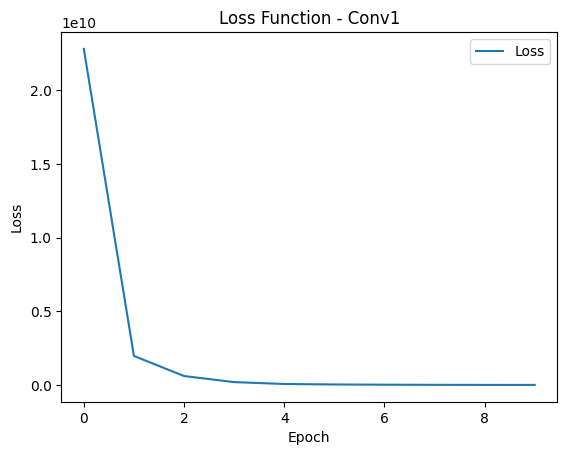

In [41]:
plt.plot(conv1_loss)
plt.title("Loss Function - Conv1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.show()

In [42]:
with torch.no_grad():
    predictions = conv1_model(X_test).numpy()
    
# Compute R2 Score
test_r2 = r2_score(y_test, predictions)
print("Test R2 Score:", test_r2)

Test R2 Score: 0.9814355812925648


In [43]:
# Create a DataFrame for Actual vs Predicted Values
conv1_acc_df = pd.DataFrame()
conv1_acc_df['Actual'] = y_test[:, 0]
conv1_acc_df['Predict'] = predictions[:, 0]
conv1_acc_df.head(10)

,Actual,Predict
0,817038.1250,825129.5000
1,817077.1250,815628.6250
2,810135.4375,809167.3125
3,806640.8750,803025.1250
4,812869.4375,800447.2500
5,804164.7500,803234.2500
6,800169.3750,800493.7500
7,805539.5625,797465.5000
8,802202.0625,797879.0000
9,805963.7500,796244.3750


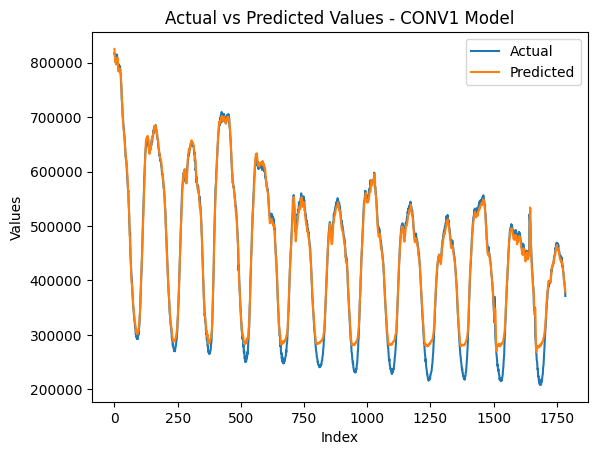

In [44]:
conv1_acc_df.plot()
plt.title("Actual vs Predicted Values - CONV1 Model")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(["Actual", "Predicted"])
plt.show()

# Multi-variate 1D conv net

In [45]:
data_train.shape #[num_samples, window_size, n_features]

torch.Size([7135, 6, 5])

In [46]:
print(data_train)

tensor([[[-0.5475, -0.2972, -0.7345, -0.7664,  0.0906],
         [-0.6745, -0.4269, -0.7822, -0.8094,  0.0353],
         [-0.7536, -0.5119, -0.8112, -0.8408, -0.0097],
         [-0.7759, -0.5961, -0.8373, -0.8637, -0.1393],
         [-0.8197, -0.7089, -0.8605, -0.8794, -0.2011],
         [-0.8349, -0.7008, -0.8810, -0.9043, -0.2629]],

        [[-0.6746, -0.4269, -0.7822, -0.8095,  0.0352],
         [-0.7536, -0.5119, -0.8113, -0.8408, -0.0098],
         [-0.7759, -0.5961, -0.8373, -0.8637, -0.1394],
         [-0.8197, -0.7089, -0.8605, -0.8794, -0.2012],
         [-0.8349, -0.7008, -0.8810, -0.9043, -0.2630],
         [-0.8753, -0.7350, -0.8936, -0.9171, -0.3502]],

        [[-0.7537, -0.5119, -0.8113, -0.8408, -0.0099],
         [-0.7760, -0.5961, -0.8373, -0.8638, -0.1395],
         [-0.8197, -0.7089, -0.8605, -0.8794, -0.2013],
         [-0.8349, -0.7008, -0.8811, -0.9043, -0.2631],
         [-0.8753, -0.7350, -0.8936, -0.9171, -0.3503],
         [-0.8938, -0.7697, -0.9291, -0.9508

In [47]:
print(data_test[0:1])

tensor([[[1.2218, 0.8835, 1.2800, 1.2275, 0.8969],
         [1.3482, 0.9326, 1.2158, 1.1911, 0.9147],
         [1.2045, 0.8740, 1.2164, 1.1746, 0.9316],
         [1.5712, 0.9851, 1.2441, 1.2493, 0.9346],
         [1.4261, 0.9571, 1.4023, 1.3799, 0.9468],
         [1.2482, 0.9054, 1.3874, 1.4033, 0.8929]]])


In [48]:
print(y_train)

tensor([[543777.6875],
        [532706.0000],
        [514802.0312],
        ...,
        [830192.7500],
        [830862.7500],
        [833568.3750]])


In [49]:
class MConv1D(nn.Module):
    def __init__(self, n_filters=24, fsize=6, window_size=5, n_features=6):
        super(MConv1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=n_filters, kernel_size=fsize, padding='same')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_filters * window_size, 1800)
        self.fc2 = nn.Linear(1800, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        #x = x.view(x.size(0), -1)  # Flatten the output for the dense layers
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
n_filters = 24
fsize = 6
window_size = data_train.shape[2]  # Replace with your window_size value
n_features = data_train.shape[1]  # Replace with the number of features from your data

conv1_mult_model = MConv1D(n_filters=n_filters, fsize=fsize, window_size=window_size, n_features=n_features)

In [50]:
print(conv1_mult_model)

MConv1D(
  (conv1): Conv1d(6, 24, kernel_size=(6,), stride=(1,), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=1800, bias=True)
  (fc2): Linear(in_features=1800, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [51]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv1_mult_model.parameters(), lr=0.001)
epochs = 10
batch_size = 10

mconv1_loss = []

for epoch in range(epochs):
    conv1_mult_model.train()  # Set the model to training mode
    total_loss = 0

    for i in range(0, len(data_train), batch_size):
        X_batch = data_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        optimizer.zero_grad()
        outputs = conv1_mult_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_train)
    mconv1_loss.append(avg_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 18423373200.3521
Epoch 2/10, Loss: 5646267033.9005
Epoch 3/10, Loss: 732731226.1990
Epoch 4/10, Loss: 281374914.7620
Epoch 5/10, Loss: 219696632.6006
Epoch 6/10, Loss: 186303079.8774
Epoch 7/10, Loss: 166603223.1052
Epoch 8/10, Loss: 152787936.3154
Epoch 9/10, Loss: 141530027.7926
Epoch 10/10, Loss: 132751864.7460


In [52]:
mconv1_loss

[18423373200.352066,
 5646267033.900491,
 732731226.199019,
 281374914.7620182,
 219696632.6005606,
 186303079.87743518,
 166603223.10518572,
 152787936.31541696,
 141530027.7926419,
 132751864.74604064]

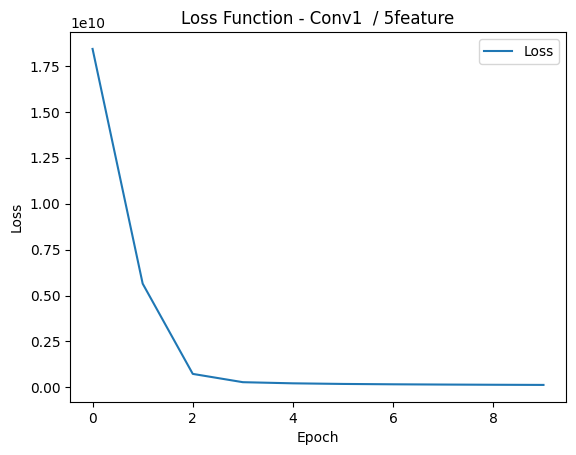

In [53]:
plt.plot(mconv1_loss)
plt.title("Loss Function - Conv1  / 5feature")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.show()

In [54]:
with torch.no_grad():
    predictions = conv1_mult_model(data_test).numpy()
    
# Compute R2 Score
test_r2 = r2_score(y_test, predictions)
print("Test R2 Score:", test_r2)

Test R2 Score: 0.7708128396153082


In [55]:
data_test.shape

torch.Size([1785, 6, 5])

In [56]:
# Create a DataFrame for Actual vs Predicted Values
mconv1_acc_df = pd.DataFrame()
mconv1_acc_df['Actual'] = y_test[:, 0]
mconv1_acc_df['Predict'] = predictions[:, 0]
mconv1_acc_df.head(10)

,Actual,Predict
0,817038.1250,842783.3125
1,817077.1250,835364.6875
2,810135.4375,832392.5625
3,806640.8750,826056.6875
4,812869.4375,819890.3125
5,804164.7500,824046.0625
6,800169.3750,820819.3125
7,805539.5625,818606.8750
8,802202.0625,826759.8750
9,805963.7500,839961.4375


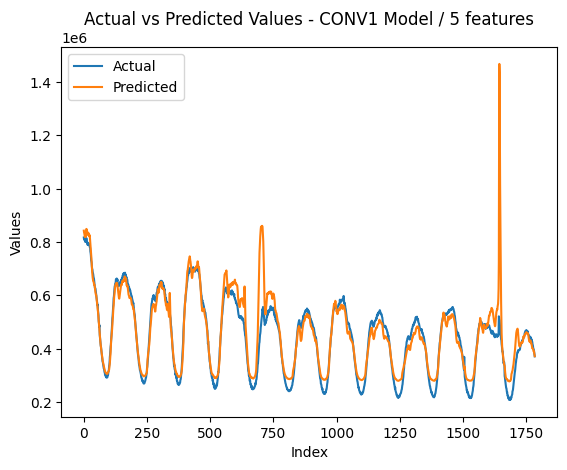

In [57]:
mconv1_acc_df.plot()
plt.title("Actual vs Predicted Values - CONV1 Model / 5 features")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(["Actual", "Predicted"])
plt.show()

# CONV 2D

In [58]:
class BasicConv2D(nn.Module):
    def __init__(self, n_filters=24, fsize=2, window_size=5, n_features=6):
        super(BasicConv2D, self).__init__()

        # Conv2D layer
        self.conv1 = nn.Conv2d(in_channels=n_features, out_channels=n_filters, kernel_size=(1, fsize), padding='same')
        # Calculate the flattened size after Conv2D
        self.flattened_size = n_filters * window_size * 1
        # Dense layers
        self.fc1 = nn.Linear(self.flattened_size, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(-1, self.flattened_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
n_filters = 24
fsize = 2
window_size = 5  # Replace with your window_size value
n_features = 6   # Replace with the number of features from your data

conv2d_model = BasicConv2D(n_filters=n_filters, fsize=fsize, window_size=window_size, n_features=n_features)

In [59]:
data_train_wide = data_train.reshape((data_train.shape[0], data_train.shape[1], data_train.shape[2], 1))
data_test_wide = data_test.reshape((data_test.shape[0], data_test.shape[1], data_test.shape[2], 1))

In [79]:
data_train_wide.shape

torch.Size([7135, 6, 5, 1])

In [60]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv2d_model.parameters(), lr=0.0001)
epochs = 10

conv2d_loss= []

# Assuming data_train_wide and y_train are already tensors and properly shaped
for epoch in range(epochs):
    conv2d_model.train()  # Set model to training mode
    total_loss = 0

    for i in range(len(data_train_wide)):
        # Forward pass
        outputs = conv2d_model(data_train_wide[i].unsqueeze(0))  # Add batch dimension
        loss = criterion(outputs, y_train[i].unsqueeze(0))  # Add batch dimension

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(data_train_wide)
    conv2d_loss.append(avg_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_train_wide):.4f}')

Epoch [1/10], Loss: 205930822567.7480
Epoch [2/10], Loss: 25610489090.5870
Epoch [3/10], Loss: 5919819464.9667
Epoch [4/10], Loss: 1025994581.9493
Epoch [5/10], Loss: 716493306.5376
Epoch [6/10], Loss: 657956870.8995
Epoch [7/10], Loss: 620722411.8854
Epoch [8/10], Loss: 586394368.7860
Epoch [9/10], Loss: 555468980.8331
Epoch [10/10], Loss: 525820200.0210


In [78]:
print(conv2d_model)

BasicConv2D(
  (conv1): Conv2d(6, 24, kernel_size=(1, 2), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=120, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


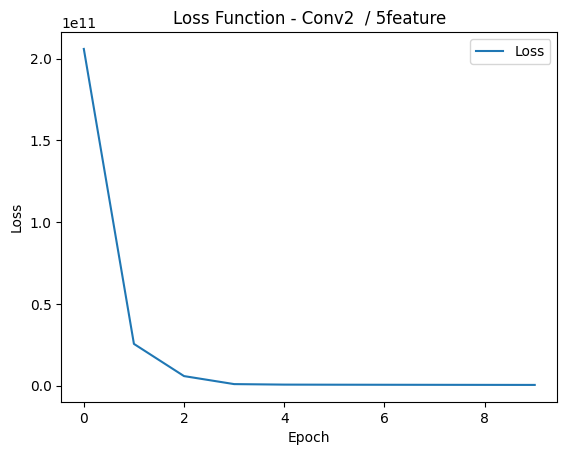

In [61]:
plt.plot(conv2d_loss)
plt.title("Loss Function - Conv2  / 5feature")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.show()

In [62]:
data_train_wide.shape

torch.Size([7135, 6, 5, 1])

In [63]:
with torch.no_grad():
    predictions = conv2d_model(data_test_wide).numpy()
    
# Compute R2 Score
test_r2 = r2_score(y_test, predictions)
print("Test R2 Score:", test_r2)

Test R2 Score: 0.6308109512090796


In [64]:
# Create a DataFrame for Actual vs Predicted Values
conv2_acc_df = pd.DataFrame()
conv2_acc_df['Actual'] = y_test[:, 0]
conv2_acc_df['Predict'] = predictions[:, 0]
conv2_acc_df.head(10)

,Actual,Predict
0,817038.1250,806581.4375
1,817077.1250,805934.8125
2,810135.4375,804271.5625
3,806640.8750,797084.5000
4,812869.4375,795126.0625
5,804164.7500,801096.8750
6,800169.3750,795062.3750
7,805539.5625,796053.2500
8,802202.0625,803016.5625
9,805963.7500,813695.6875


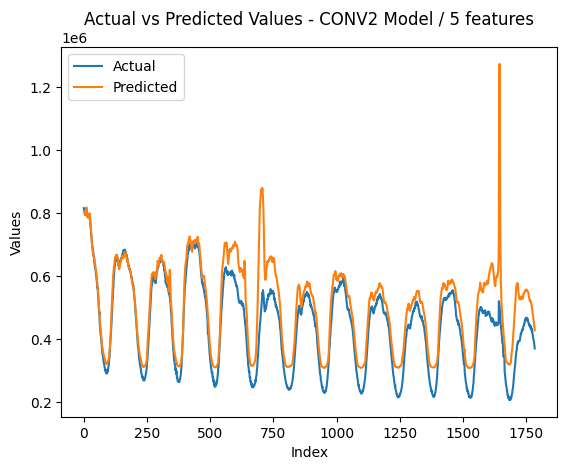

In [65]:
conv2_acc_df.plot()
plt.title("Actual vs Predicted Values - CONV2 Model / 5 features")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(["Actual", "Predicted"])
plt.show()

# Deeper conv2D

In [66]:
class DeeperConv2D(nn.Module):
    def __init__(self, n_filters=24, fsize=2, window_size=5, n_features=6, hour_filter=6):
        super(DeeperConv2D, self).__init__()

        # First 2D convolution layer
        self.conv1 = nn.Conv2d(in_channels=n_features, out_channels=n_filters, kernel_size=(1, fsize), padding='same')
        
        # Second 2D convolution layer
        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=(hour_filter, 1), padding='same')
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(n_filters * window_size * 1, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.conv1(x)   # First convolution with linear activation
        x = torch.relu(self.conv2(x))    # Second convolution with ReLU activation
        x = self.flatten(x)          # Flatten the output
        x = torch.relu(self.fc1(x))      # First dense layer with ReLU activation
        x = torch.relu(self.fc2(x))      # Second dense layer with ReLU activation
        x = self.fc3(x)              # Output layer
        return x

In [74]:
n_filters = 24
fsize = 2
window_size = data_train_wide.shape[2]  # Based on the data shape
n_features = data_train_wide.shape[1]   # Based on the data shape
hour_filter = 6

deeper_conv2d_model = DeeperConv2D(n_filters=n_filters, fsize=fsize, window_size=window_size, n_features=n_features, hour_filter=hour_filter)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(deeper_conv2d_model.parameters(), lr=0.0005)

# Training loop
epochs = 10
batch_size = 10

dconv2d_loss = []
dconv2d_mse = []
dconv2d_rmse = []

for epoch in range(epochs):
    deeper_conv2d_model.train()  # Set the model to training mode
    total_loss = 0

    for i in range(0, len(data_train_wide), batch_size):
        X_batch = data_train_wide[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        optimizer.zero_grad()
        outputs = deeper_conv2d_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_train_wide)
    mse = avg_loss
    rmse = math.sqrt(mse)

    dconv2d_loss.append(avg_loss)
    dconv2d_mse.append(mse)
    dconv2d_rmse.append(rmse)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

Epoch [1/10], Loss: 20772470129.0988
Epoch [2/10], Loss: 881594260.8734
Epoch [3/10], Loss: 289670957.3720
Epoch [4/10], Loss: 272157917.3228
Epoch [5/10], Loss: 257002038.3082
Epoch [6/10], Loss: 235725730.8828
Epoch [7/10], Loss: 208275209.6527
Epoch [8/10], Loss: 176629385.4244
Epoch [9/10], Loss: 145416292.9673
Epoch [10/10], Loss: 120961266.6632


In [82]:
print(deeper_conv2d_model)

DeeperConv2D(
  (conv1): Conv2d(6, 24, kernel_size=(1, 2), stride=(1, 1), padding=same)
  (conv2): Conv2d(24, 24, kernel_size=(6, 1), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [75]:
dconv2d_mse

[20772470129.09881,
 881594260.8734407,
 289670957.37203926,
 272157917.3228451,
 257002038.30819902,
 235725730.88276103,
 208275209.65269798,
 176629385.42438683,
 145416292.967274,
 120961266.66320953]

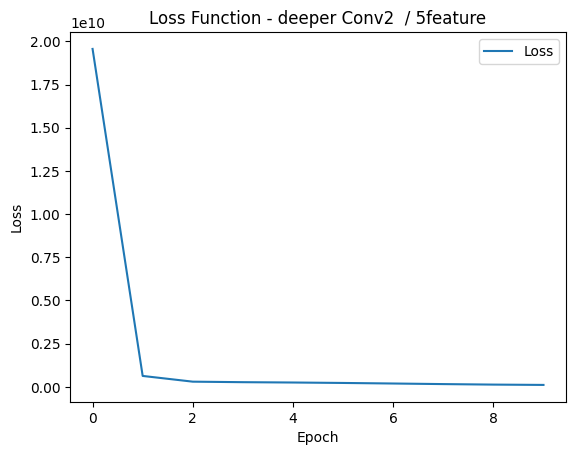

In [68]:
plt.plot(dconv2d_loss)
plt.title("Loss Function - deeper Conv2  / 5feature")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.show()

In [77]:
with torch.no_grad():
    deeper_conv2d_model.eval()
    predictions = deeper_conv2d_model(data_test_wide).numpy()
    
# Compute R2 Score
test_r2 = r2_score(y_test, predictions)
print("Test R2 Score:", test_r2)

# Compute MSE
test_mse = mean_squared_error(y_test, predictions)
print("Test MSE:", test_mse)

# Compute RMSE
test_rmse = math.sqrt(test_mse)
print("Test RMSE:", test_rmse)

Test R2 Score: 0.6873975019493703
Test MSE: 5980612600.0
Test RMSE: 77334.42059005809


In [70]:
# Create a DataFrame for Actual vs Predicted Values
dconv2_acc_df = pd.DataFrame()
dconv2_acc_df['Actual'] = y_test[:, 0]
dconv2_acc_df['Predict'] = predictions[:, 0]
dconv2_acc_df.head(10)

,Actual,Predict
0,817038.1250,823780.9375
1,817077.1250,819822.0625
2,810135.4375,819862.9375
3,806640.8750,817803.1875
4,812869.4375,813063.8750
5,804164.7500,821285.9375
6,800169.3750,813473.6875
7,805539.5625,819211.4375
8,802202.0625,818823.3125
9,805963.7500,831526.3125


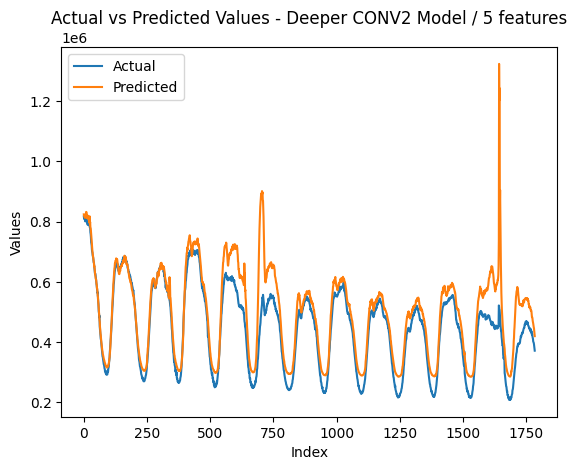

In [71]:
dconv2_acc_df.plot()
plt.title("Actual vs Predicted Values - Deeper CONV2 Model / 5 features")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(["Actual", "Predicted"])
plt.show()